In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Expansion to Vector Es and Rs, Symmetric Weights

In [8]:
def step(x, E, R, Us):
    inp = x
    for i in range(len(Us)):
        E[i] = inp - Us[i](R[i])
        R[i] = R[i] + F.linear(E[i], Us[i].weight.T, None)
        inp = R[i]
    return E, R

In [9]:
sizes = [4, 3, 2]
# Parameter Initialisation
Us = [nn.Linear(sizes[i+1], sizes[i], bias=False) for i in range(len(sizes)-1)]

# Initialise Dataset
x = torch.randint(1, 4, (sizes[0],)).float()
E = [torch.zeros((sizes[i],)) for i in range(len(sizes)-1)]
R = [torch.zeros((sizes[i+1],)) for i in range(len(sizes)-1)]
i = 0

print("Initial state:")
print(f"x: {x}")
print(f"e: {E}")
print(f"r: {R}")

Initial state:
x: tensor([3., 3., 2., 2.])
e: [tensor([0., 0., 0., 0.]), tensor([0., 0., 0.])]
r: [tensor([0., 0., 0.]), tensor([0., 0.])]


In [14]:
# Manual Iteration with no learning
i += 1
with torch.no_grad():
    E, R = step(x, E, R, Us)

print(f"state after {i} steps:")
print(f"x: {x}")
print(f"pred: {Us[0](R[0]).data}")
print(f"e: {E}  - MeanAbs: {sum([e.abs().mean() for e in E]) / len(Us):.4f}")
print(f"r: {R}")

state after 5 steps:
x: tensor([3., 3., 2., 2.])
pred: tensor([ 0.5013,  0.7120,  0.1352, -0.5959])
e: [tensor([2.5950, 2.3881, 1.8752, 2.5059]), tensor([ 1.6283, -0.4553, -0.3048])]  - MeanAbs: 1.5686
r: [tensor([ 2.5942, -2.0015, -0.5578]), tensor([-3.0240, -2.1182])]


Learning with symmetric weights

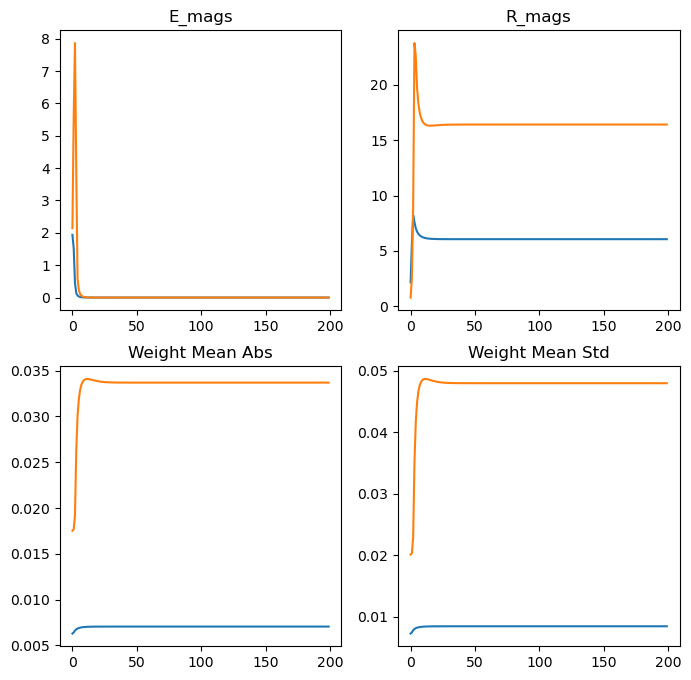

In [19]:
# Parameter Initialisation
sizes = [784, 64, 8]
steps = 5
Us = [nn.Linear(sizes[i+1], sizes[i], bias=False) for i in range(len(sizes)-1)]
for i in range(len(Us)):
    Us[i].weight.data *= 0.1
sym_E_mags = [[] for _ in range(len(Us))]
sym_R_mags = [[] for _ in range(len(Us))]
sym_Us_mags = [[] for _ in range(len(Us))]
sym_Us_stds = [[] for _ in range(len(Us))]

# Build dataset
batch_size = 1
X = torch.randint(1, 4, (batch_size, sizes[0],)).float()

# Hyperparameters
lr = 0.000034
epochs = 200
reg_coeff = 0.0

# Learning Loop
for ep in range(epochs):
    epoch_E_mags = torch.zeros(len(Us), batch_size)
    epoch_R_mags = torch.zeros(len(Us), batch_size)
    epoch_Us_mags = torch.zeros(len(Us), batch_size)
    epoch_Us_stds = torch.zeros(len(Us), batch_size)

    for b in range(batch_size):
        x = X[b]

        E = [torch.zeros((sizes[i],)) for i in range(len(sizes)-1)]
        R = [torch.zeros((sizes[i+1],)) for i in range(len(sizes)-1)]

        for step_i in range(steps):
            with torch.no_grad():
                E, R = step(x, E, R, Us)

            if step_i > 0:
                with torch.no_grad():
                    for i in range(len(Us)):
                        Us[i].weight.grad = -(E[i].unsqueeze(1) * R[i].unsqueeze(0)) # -ve because we are performing grad descent, yet we want to increase connectivity 
            
                # L2 Regularisation
                reg = reg_coeff * sum([U.weight.square().mean() for U in Us])
                reg.backward()
                
                # Parameter Update
                for i in range(len(Us)):
                    Us[i].weight.data -= lr * Us[i].weight.grad

        # Stat tracking
        for i in range(len(Us)):
            epoch_E_mags[i, b] = E[i].abs().mean().item()
            epoch_R_mags[i, b] = R[i].abs().mean().item()
            epoch_Us_mags[i, b] = Us[i].weight.data.abs().mean().item()
            epoch_Us_stds[i, b] = Us[i].weight.data.std().item()

    # Stat tracking
    for i in range(len(Us)):
        sym_E_mags[i].append(epoch_E_mags[i].mean().item())
        sym_R_mags[i].append(epoch_R_mags[i].mean().item())
        sym_Us_mags[i].append(epoch_Us_mags[i].mean().item())
        sym_Us_stds[i].append(epoch_Us_stds[i].mean().item())

# Plot
fig, axs = plt.subplots(2,2, figsize=(8,8))
for i in range(len(Us)):
    axs[0,0].plot(sym_E_mags[i], label=f"Layer {i}")
    axs[0,0].set_title('E_mags')
    axs[0,1].plot(sym_R_mags[i], label=f"Layer {i}")
    axs[0,1].set_title('R_mags')
    axs[1,0].plot(sym_Us_mags[i], label=f"Layer {i}")
    axs[1,0].set_title('Weight Mean Abs')
    axs[1,1].plot(sym_Us_stds[i], label=f"Layer {i}")
    axs[1,1].set_title('Weight Mean Std')
plt.show()


In [182]:
type(sym_E_mags)

list

In [172]:
test = torch.randn(3, 10)
for t in test:
    print(t)

tensor([ 0.4413,  0.7232,  1.1901,  2.0988, -0.9992, -0.3503, -0.8215,  1.3005,
         0.6081, -0.5852])
tensor([-0.3617, -0.5920,  0.0907, -0.9813, -0.5503,  0.4677,  0.0228,  0.7460,
         2.4637,  1.8969])
tensor([-0.2468, -0.3454, -0.7954, -1.0647, -0.7915,  1.2810, -0.3618,  1.1772,
        -0.4163, -0.2159])


In [69]:
# error should be bigger for untrained x
dataset_e_mags = torch.zeros(len(X))
for i, x in enumerate(X):
    e = torch.zeros((sizes[0],))
    r = torch.zeros((sizes[1],))
    for _ in range(5):
        e = e.detach()
        r = r.detach()
        e, r = step(x, e, r, U)
    dataset_e_mags[i] = e.abs().mean().item()
print(f"Dataset e_mag: {dataset_e_mags.mean().item():.4f}")

x = torch.randint(1, 4, (sizes[0],)).float()
for _ in range(5):
    e = e.detach()
    r = r.detach()
    e, r = step(x, e, r, U)
print(f"Untrained e_mag: {e.abs().mean().item():.4f}")

Dataset e_mag: 0.2241
Untrained e_mag: 0.3878


In [16]:
# New Update rule with assymetric weights
def step2(x, e, r, U, V):
    with torch.no_grad():
        e = x - U(r)
    r = r + V(e)
    return e, r

In [17]:
sizes = [4,4]
# Parameter Initialisation
U = nn.Linear(sizes[1],sizes[0], bias=False)
V = nn.Linear(sizes[0],sizes[1], bias=False)

# Data Initialisation
x = torch.randint(1, 4, (sizes[0],)).float()
e = torch.zeros((sizes[0],))
r = torch.zeros((sizes[1],))
i = 0

print("Initial state:")
print(f"x: {x}")
print(f"e: {e}")
print(f"r: {r}")

Initial state:
x: tensor([3., 3., 1., 2.])
e: tensor([0., 0., 0., 0.])
r: tensor([0., 0., 0., 0.])


In [21]:
# Manual Iteration with no learning
i += 1
e = e.detach()
r = r.detach()
e, r = step2(x, e, r, U, V)

print(f"state after {i} steps:")
print(f"x: {x}")
print(f"pred: {U(r).data}")
print(f"e: {e}  - MeanAbs: {e.abs().mean():.4f}")
print(f"r: {r.data}")

state after 4 steps:
x: tensor([3., 3., 1., 2.])
pred: tensor([-0.5198,  5.2693, -5.0684, -1.0382])
e: tensor([ 3.1197, -0.5372,  4.8007,  2.8865])  - MeanAbs: 2.8360
r: tensor([ -0.8681,   6.6333,  -3.6063, -10.8218])


Learning with Assymetric weights

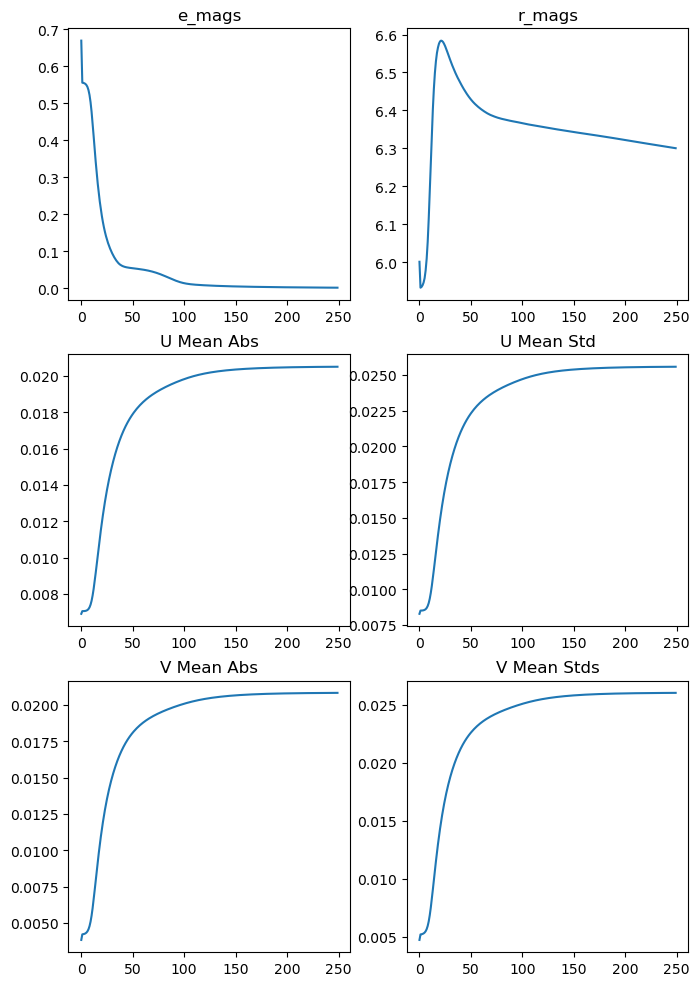

In [87]:
# Parameter Initialisation
sizes = [784, 64]
steps = 5
U = nn.Linear(sizes[1], sizes[0], bias=False)
V = nn.Linear(sizes[0], sizes[1], bias=False)
U.weight.data *= 0.1
V.weight.data *= 0.1
asym_e_mags = []
asym_r_mags = []
asym_U_mags = []
asym_U_stds = []
asym_V_mags = []
asym_V_stds = []

# Build dataset
batch_size = 32
X = torch.randint(1, 4, (batch_size, sizes[0],)).float()

# Hyperparameters
lr = 0.000034
epochs = 250
reg_coeff = 0.0

# Training Loop
for ep in range(epochs):
    epoch_e_mags = torch.zeros(batch_size)
    epoch_r_mags = torch.zeros(batch_size)
    epoch_U_mags = torch.zeros(batch_size)
    epoch_U_stds = torch.zeros(batch_size)
    epoch_V_mags = torch.zeros(batch_size)
    epoch_V_stds = torch.zeros(batch_size)

    for b in range(batch_size):
        x = X[b]

        e = torch.zeros((sizes[0],))
        r = torch.zeros((sizes[1],))


        for step_i in range(steps):
            
            e = e.detach()
            r = r.detach()
            e, r = step2(x, e, r, U, V)

            if step_i > 0:
                with torch.no_grad():
                    U.weight.grad = -(e.unsqueeze(1) @ r.unsqueeze(0)) # Ideally this is performed halfway through step2()
                    V.weight.grad = -(r.unsqueeze(1) @ e.unsqueeze(0))

                reg = reg_coeff * (U.weight.square().mean() + V.weight.square().mean())
                reg.backward()

                U.weight.data -= lr * U.weight.grad
                V.weight.data -= lr * V.weight.grad
                
        # Stat tracking
        epoch_e_mags[b] = e.abs().mean().item()
        epoch_r_mags[b] = r.abs().mean().item()
        epoch_U_mags[b] = U.weight.data.abs().mean().item()
        epoch_U_stds[b] = U.weight.data.std().item()
        epoch_V_mags[b] = V.weight.data.abs().mean().item()
        epoch_V_stds[b] = V.weight.data.std().item()
    
    # Stat tracking
    asym_e_mags.append(epoch_e_mags.mean().item())
    asym_r_mags.append(epoch_r_mags.mean().item())
    asym_U_mags.append(epoch_U_mags.mean().item())
    asym_U_stds.append(epoch_U_stds.mean().item())
    asym_V_mags.append(epoch_V_mags.mean().item())
    asym_V_stds.append(epoch_V_stds.mean().item())



fig, axs = plt.subplots(3, 2, figsize=(8,12))
axs[0,0].plot(asym_e_mags)
axs[0,0].set_title('e_mags')
axs[0,1].plot(asym_r_mags)
axs[0,1].set_title('r_mags')
axs[1,0].plot(asym_U_mags, label="U Mean Abs")
axs[1,0].set_title('U Mean Abs')
axs[1,1].plot(asym_U_stds, label="U Mean Stds")
axs[1,1].set_title('U Mean Std')
axs[2,0].plot(asym_V_mags, label="V Mean Abs")
axs[2,0].set_title('V Mean Abs')
axs[2,1].plot(asym_V_stds, label="V Mean Stds")
axs[2,1].set_title('V Mean Stds')
plt.show()

In [88]:
# error is bigger for untrained x
dataset_e_mags = torch.zeros(len(X))
for i, x in enumerate(X):
    e = torch.zeros((sizes[0],))
    r = torch.zeros((sizes[1],))
    for _ in range(5):
        e = e.detach()
        r = r.detach()
        e, r = step2(x, e, r, U, V)
    dataset_e_mags[i] = e.abs().mean().item()
print(f"Dataset e_mag: {dataset_e_mags.mean().item():.4f}")

x = torch.randint(1, 4, (sizes[0],)).float()
for _ in range(4):
    e = e.detach()
    r = r.detach()
    e, r = step2(x, e, r, U, V)
print(f"Untrained x: {x.shape} - e.mag: {e.abs().mean().item():.4f}")

Dataset e_mag: 0.0047
Untrained x: torch.Size([784]) - e.mag: 0.6861


Symmetric VS Asymmetric

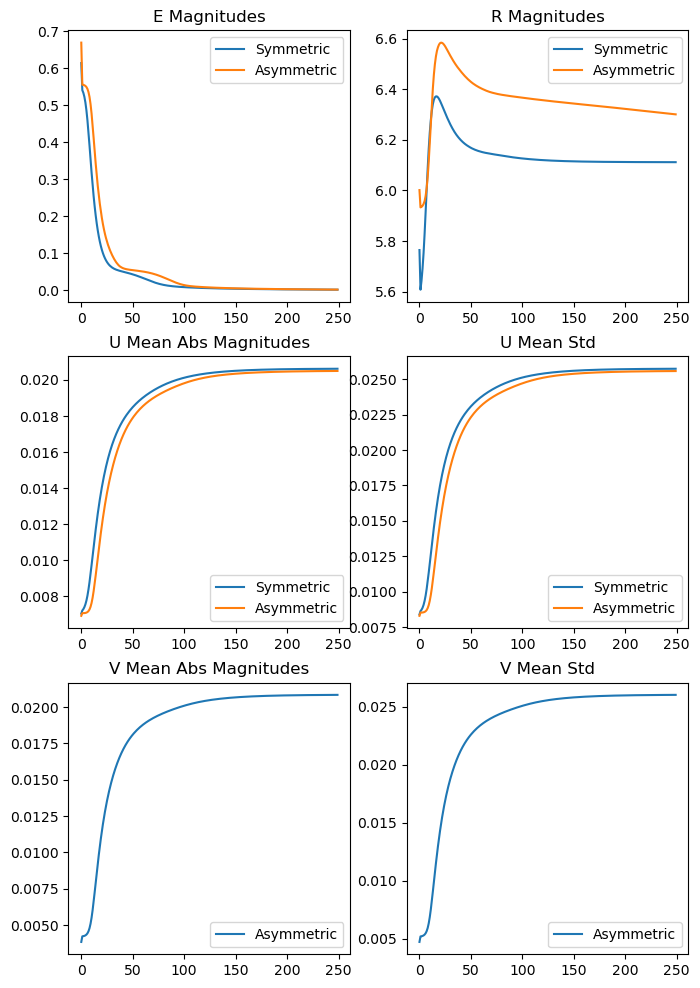

In [89]:
fig, axs = plt.subplots(3, 2, figsize=(8,12))
axs[0,0].plot(sym_e_mags, label="Symmetric")
axs[0,0].plot(asym_e_mags, label="Asymmetric")
axs[0,0].legend()
axs[0,0].set_title('E Magnitudes')
axs[0,1].plot(sym_r_mags, label="Symmetric")
axs[0,1].plot(asym_r_mags, label="Asymmetric")
axs[0,1].legend()
axs[0,1].set_title('R Magnitudes')
axs[1,0].plot(sym_U_mags, label="Symmetric")
axs[1,0].plot(asym_U_mags, label="Asymmetric")
axs[1,0].legend()
axs[1,0].set_title('U Mean Abs Magnitudes')
axs[1,1].plot(sym_U_stds, label="Symmetric")
axs[1,1].plot(asym_U_stds, label="Asymmetric")
axs[1,1].legend()
axs[1,1].set_title('U Mean Std')
axs[2,0].plot(asym_V_mags, label="Asymmetric")
axs[2,0].legend()
axs[2,0].set_title('V Mean Abs Magnitudes')
axs[2,1].plot(asym_V_stds, label="Asymmetric")
axs[2,1].legend()
axs[2,1].set_title('V Mean Std')
plt.show()
